In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [14]:
candidate_sentences = pd.read_csv("new.csv")
candidate_sentences.shape

(23, 2)

In [15]:
candidate_sentences['sentences'].sample(5)

5                                                                               Sift together the all-purpose flour and baking soda.
1                                                                                         Begin by mixing sugar and butter together.
9     You may not add the entire milk if you feel the consistency of your cake is fine and it pours down like canned condensed milk.
20                                                         If you are using an electric oven, cook at 180 degrees for 30-35 minutes.
2                                                                 Whisk well until light and fluffy with a manual whisker or a fork.
Name: sentences, dtype: object

In [16]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        print(prefix)
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
            prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [17]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [18]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentences"]):
  entity_pairs.append(get_entities(i))

 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 69.73it/s]

sponge
purpose
egg
vanilla
Vanilla

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:00<00:00, 59.71it/s]


baking
butter
pressure
baking
steel
pressure


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 47.53it/s]

metal
wire


In [19]:
entity_pairs[10:20]

[['', 'vanilla essence'],
 ['Vanilla essence', 'eggs'],
 ['', 'greased baking tin'],
 ['It', 'base'],
 ['You', 'also butter paper'],
 ['', 'prepared pressure cooker'],
 ['tin', 'cooker'],
 ['You', 'inverted steel plate'],
 ['', 'two pressure minutes'],
 ['', '35  minutes']]

In [20]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",  [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [21]:
get_relation("John completed the task")

'completed'

In [22]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentences'])]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 77.78it/s]


In [23]:
pd.Series(relations).value_counts()[:50]

add             5
Remove from     1
Sprinkle        1
is important    1
is ready        1
Pour            1
was             1
Whisk           1
Increase        1
prevent         1
remove          1
keep            1
done            1
Add             1
line            1
cook at         1
Beat            1
Begin by        1
Sift            1
dtype: int64

In [24]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [25]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

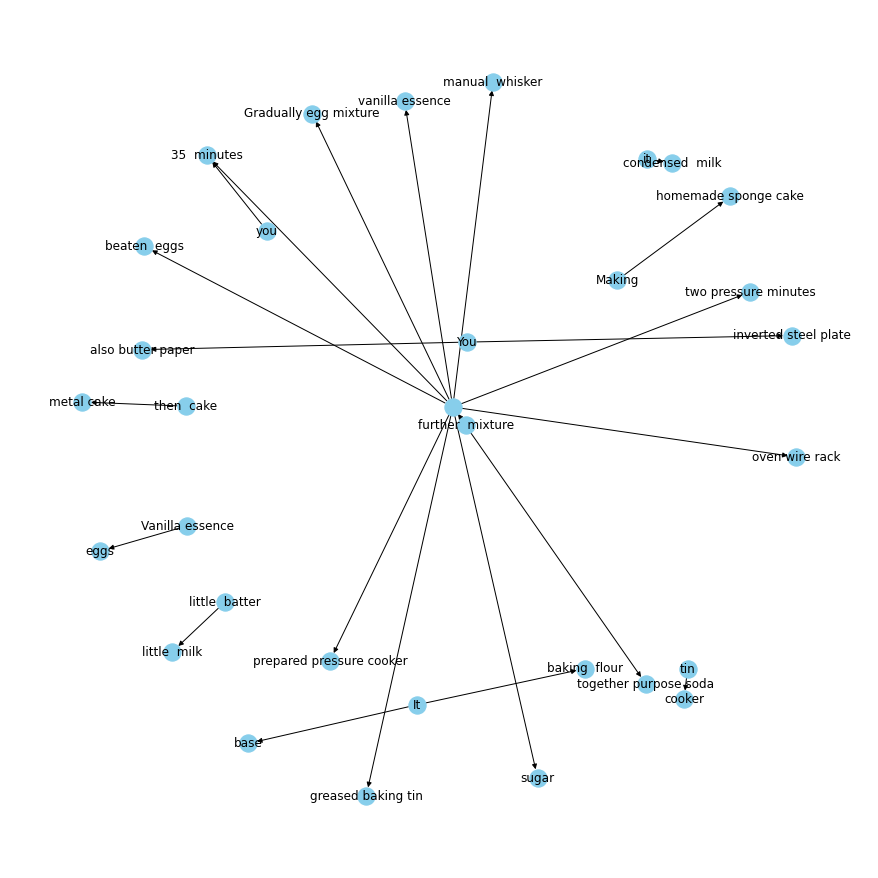

In [26]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

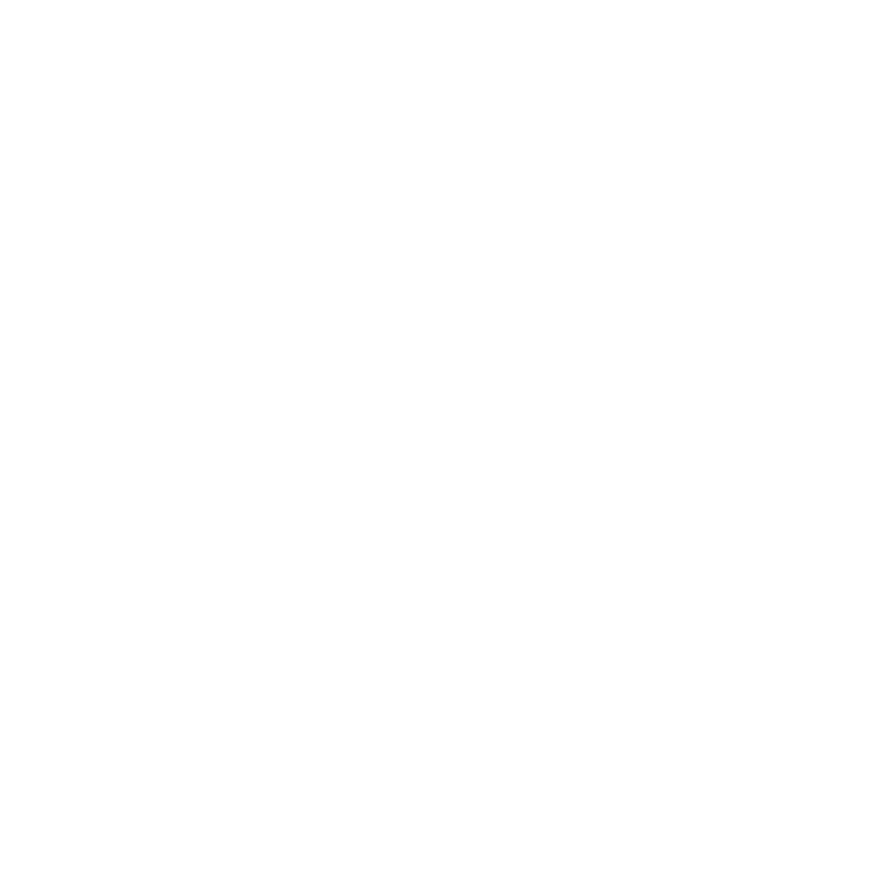

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()